<a href="https://colab.research.google.com/github/JonHaz/Capstone-2-LVMH-Sales-in-Iowa/blob/main/LVMH_Capstone_Two_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will be testing out different machine learning models to predict sales

*   ARIMA
*   Linear Regression
*   Random Forest Regression
*   XGBoost
*   Long Short Term Memory

My game plan is to


*   split the data into train and test
*   create a pipeline
*   perform 5 fold cross validation
*   use gradient boosting to determine what learning rate has the best accuracy
*   Random Search to determine what is a good enough parameter

In [1]:
#Packages I will be using
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
#https://github.com/srpraveen97/Electrical_Demand_Toronto/blob/main/Jupyter%20Notebooks/LinearModel_TimeSeries.ipynb

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# I am establishing a connection to my Sandbox within BigQuery so that I can run SQL queries to interact with the data here within Google Collab
from google.colab import auth
auth.authenticate_user()
print('Authenticated')


Authenticated


In [3]:
# Save output in a variable `df`
%%bigquery --project storied-sound-253213 df
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE vendor_number = '420'

In [4]:
df.dtypes

invoice_and_item_number     object
date                        object
store_number                object
store_name                  object
address                     object
city                        object
zip_code                    object
store_location              object
county_number               object
county                      object
category                    object
category_name               object
vendor_number               object
vendor_name                 object
item_number                 object
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtype: object

In [5]:
#applying a little data cleaning
#changing data types for 'date', 'pack', 'bottle_volume_ml'
df['date'] = pd.to_datetime(df['date'])
add_cat = ['pack', 'bottle_volume_ml']
df[add_cat] = df[add_cat].astype(str)

###**Classification DataFrame**

In [6]:
# removing fields that are unique identifiers, are redundant, or have more than 100 unique options
# Saving this as it's own DataFrame to be used with classification models
remove_cat = [ 'vendor_number','vendor_name', 'store_name', 'address','item_description', 'item_number', 'store_number', 'city', 'zip_code', 'store_location', 'county']
df_class = df.drop(columns=remove_cat).set_index('invoice_and_item_number')
df_class.head()

,date,county_number,category,category_name,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
invoice_and_item_number,,,,,,,,,,,,
INV-06546200027,2017-08-08,81,None,None,24,200,5.99,8.99,2,17.98,0.4,0.11
S09364400007,2012-12-06,85,1012210,SINGLE MALT SCOTCH,6,750,24.97,37.45,36,1348.20,27.0,7.13
S22471700021,2014-11-19,82,1701100,DECANTERS & SPECIALTY PACKAGES,6,400,14.84,22.26,6,133.56,2.4,0.63
S17621300048,2014-02-26,07,1701100,DECANTERS & SPECIALTY PACKAGES,6,900,21.99,32.99,6,197.94,5.4,1.43
S29176100152,2015-11-19,77,1701100,DECANTERS & SPECIALTY PACKAGES,6,850,25.98,38.97,2,77.94,1.7,0.45


In [7]:
# I created a lookup table in Google Sheets that grouped county number by district per the Iowa Department of Transportation
# I am importing that googlesheet and creating a dataframe

!pip install --upgrade -q gspread

import gspread
import pandas as pd
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Districts Iowa Department of Transportation').sheet1
rows = worksheet.get_all_values()
district = pd.DataFrame.from_records(rows)

In [8]:
#formatting the new data frame
column = ['count_number', 'district']
district.set_axis(column, axis=1, inplace=True)
district = district.drop(0)
district.head()

,count_number,district
1,1,3
2,2,3
3,3,3
4,4,3
5,5,2


In [9]:
#merged the district df with my classification df
df_class = df_class.merge(district,left_on='county_number', right_on='count_number')
df_class = df_class.drop(columns=['count_number'])
df_class.columns

Index(['date', 'county_number', 'category', 'category_name', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons', 'district'],
      dtype='object')

In [10]:
#adding new columns
import datetime as dt

df_class['year'] = pd.DatetimeIndex(df_class['date']).year.astype(str)
df_class['month'] = pd.DatetimeIndex(df_class['date']).month
df_class['week'] = pd.DatetimeIndex(df_class['date']).week.astype(str)
df_class['day'] = pd.DatetimeIndex(df_class['date']).day_name

dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df_class['day'] = df_class['date'].dt.dayofweek.map(dayOfWeek)

month = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10: 'October', 11:'November', 12:'December'}
df_class['month'] = df_class['date'].dt.month.map(month)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [11]:
# selecting object type columns
# one hot encoding object columns
dfo = df_class.select_dtypes(include=['object']) 
df_class = pd.concat([df_class.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)

In [12]:
df_class.head()

,date,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,county_number_1,county_number_10,county_number_11,county_number_12,county_number_13,county_number_14,county_number_15,county_number_16,county_number_17,county_number_18,county_number_19,county_number_2,county_number_20,county_number_21,county_number_22,county_number_23,county_number_24,county_number_25,county_number_26,county_number_27,county_number_28,county_number_29,county_number_3,county_number_30,county_number_31,county_number_32,county_number_33,county_number_34,county_number_35,county_number_36,county_number_37,county_number_38,county_number_39,...,week_28,week_29,week_3,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_4,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_5,week_50,week_51,week_52,week_53,week_6,week_7,week_8,week_9,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2017-08-08,5.99,8.99,2,17.98,0.40,0.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2013-11-06,9.50,14.25,2,28.50,0.75,0.20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2015-12-09,74.22,111.33,4,445.32,3.00,0.79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2017-12-26,9.02,13.53,2,27.06,0.40,0.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,2018-04-24,49.99,74.99,1,74.99,0.75,0.20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### **Regression DataFrame**

In [13]:
# let us move the date to the index
df_reg = df.set_index('date')

# let us also exclude non numerical data types
df_reg = df_reg.select_dtypes(exclude=[object])


# this is the begginings of our dataframe for regression models
df_reg.head()

,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
date,,,,,,
2017-08-08,5.99,8.99,2,17.98,0.4,0.11
2012-12-06,24.97,37.45,36,1348.20,27.0,7.13
2014-11-19,14.84,22.26,6,133.56,2.4,0.63
2014-02-26,21.99,32.99,6,197.94,5.4,1.43
2015-11-19,25.98,38.97,2,77.94,1.7,0.45


In [14]:
#I am summing up all the values and grouping them by day
reg_columns = ['state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters','volume_sold_gallons']

df_reg = df_reg.groupby('date')[reg_columns].sum()

I created two data frames one for regression and the other targeted at classification to answer.

1. what is the predicted sales for the state of Iowa
2. What region of the state can we predict those sales 

#**Data Visualizations**
This wouldn't be a capstone without them!

In [15]:
df_reg.head()

,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
date,,,,,,
2012-01-03,1646.48,2469.79,784,15105.42,403.23,106.65
2012-01-04,1371.22,2056.89,431,8984.70,251.53,66.50
2012-01-05,2153.53,3230.34,1042,18980.12,511.03,135.17
2012-01-09,1418.60,2128.05,722,12762.83,341.10,90.21
2012-01-10,858.38,1287.57,575,8932.77,239.97,63.50


In [16]:
df_class.head()

,date,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,county_number_1,county_number_10,county_number_11,county_number_12,county_number_13,county_number_14,county_number_15,county_number_16,county_number_17,county_number_18,county_number_19,county_number_2,county_number_20,county_number_21,county_number_22,county_number_23,county_number_24,county_number_25,county_number_26,county_number_27,county_number_28,county_number_29,county_number_3,county_number_30,county_number_31,county_number_32,county_number_33,county_number_34,county_number_35,county_number_36,county_number_37,county_number_38,county_number_39,...,week_28,week_29,week_3,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_4,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_5,week_50,week_51,week_52,week_53,week_6,week_7,week_8,week_9,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2017-08-08,5.99,8.99,2,17.98,0.40,0.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2013-11-06,9.50,14.25,2,28.50,0.75,0.20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2015-12-09,74.22,111.33,4,445.32,3.00,0.79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2017-12-26,9.02,13.53,2,27.06,0.40,0.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,2018-04-24,49.99,74.99,1,74.99,0.75,0.20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Regression Visuals

In [17]:
df_reg.describe()

,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000
mean,2335.631474,3503.938492,1554.190435,30285.201762,710.198651,187.374265
std,1033.336403,1550.229262,952.171134,18341.280156,406.449299,107.072210
min,5.000000,7.500000,1.000000,25.440000,0.050000,0.010000
25%,1663.150000,2495.180000,922.000000,18007.910000,449.210000,118.780000
50%,2298.860000,3448.730000,1415.000000,27514.150000,668.130000,176.440000
75%,2890.470000,4336.460000,1987.000000,38037.130000,889.690000,234.530000
max,8406.480000,12611.870000,8163.000000,171227.240000,3735.230000,985.030000


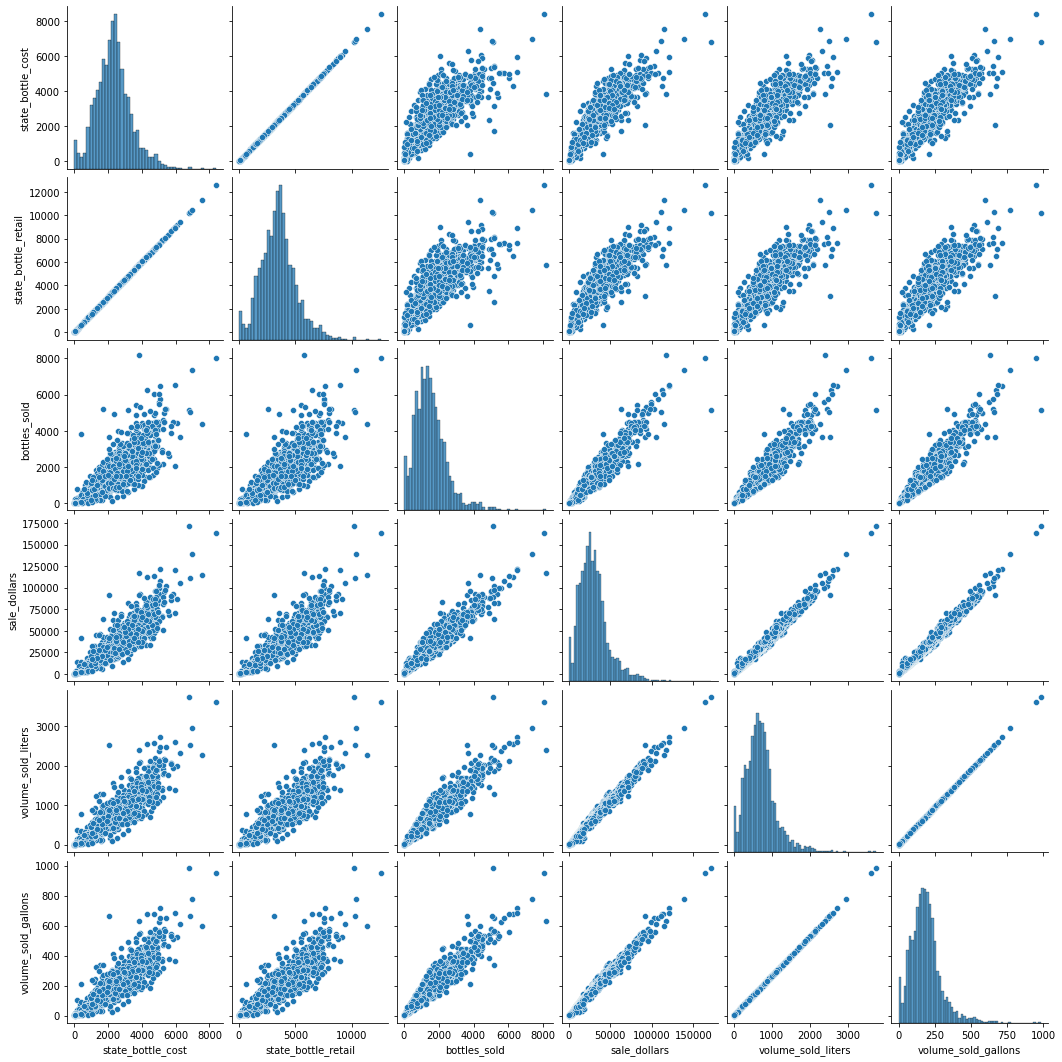

In [18]:
sns.pairplot(df_reg)

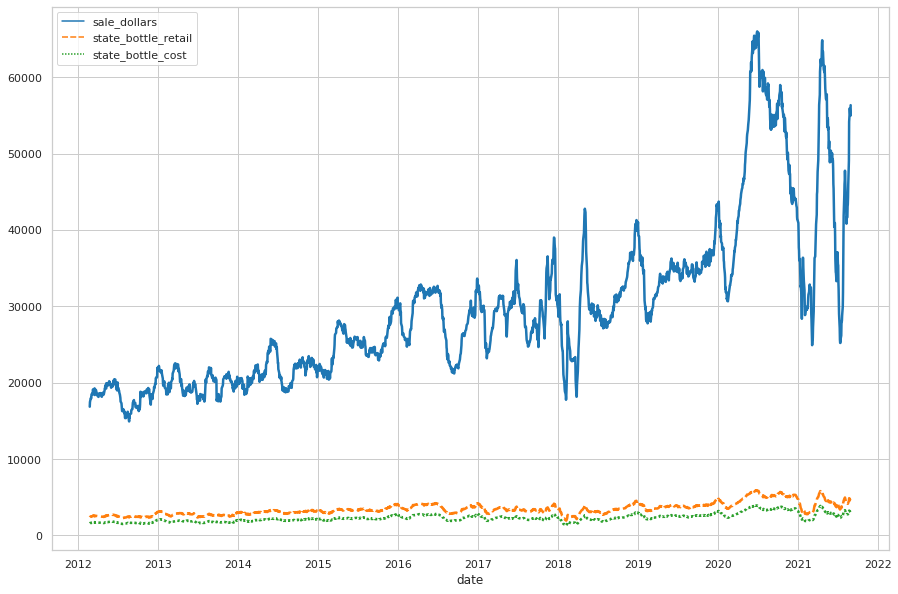

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,10))

data = pd.DataFrame(df_reg, df_reg.index, columns=['sale_dollars','state_bottle_retail','state_bottle_cost'])
data = data.rolling(30).mean()

sns.lineplot(data=data, palette="tab10", linewidth=2.5)

Additional Visuals

In [20]:


#merged the district df with my existing df
new_df =df.merge(district,left_on='county_number', right_on='count_number')

#adding new columns
new_df['year'] = pd.DatetimeIndex(new_df['date']).year
new_df['month'] = pd.DatetimeIndex(new_df['date']).month
new_df['week'] = pd.DatetimeIndex(new_df['date']).week

sales_district_year = new_df.groupby(['district','year'])['sale_dollars'].agg('sum')
sales_district_month = new_df.groupby(['district','month'])['sale_dollars'].agg('sum')
sales_district_week = new_df.groupby(['district','week'])['sale_dollars'].agg('sum')
sales_district_year = sales_district_year.reset_index(level='district')
sales_district_month = sales_district_month.reset_index(level='district')
sales_district_week = sales_district_week.reset_index(level='district')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if __name__ == '__main__':


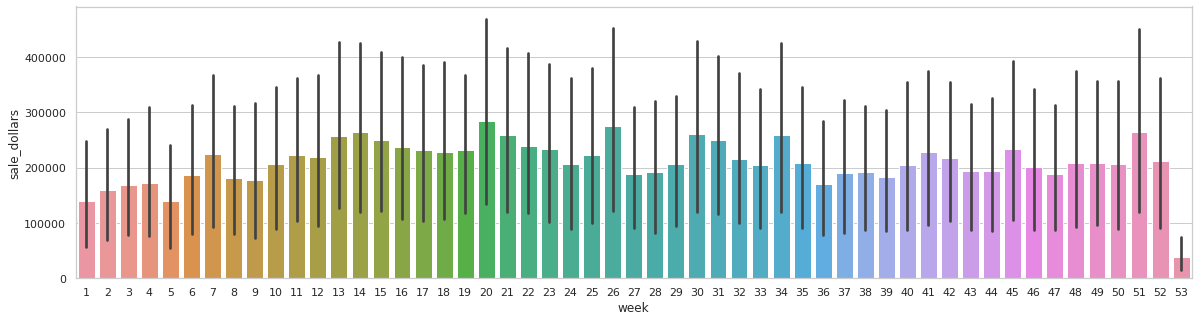

In [21]:
plt.figure(figsize=(20,5))
x = sales_district_week.index
y = sales_district_week['sale_dollars']
hue = sales_district_week['district']

sns.barplot(x=x, y=y)

In [22]:
sales_district_year.head()

,district,sale_dollars
year,,
2012,1,42745.55
2013,1,42995.90
2014,1,45753.00
2015,1,41908.83
2016,1,52867.27


[Text(0, 0.5, 'Millions'), Text(0.5, 0, 'Districts')]

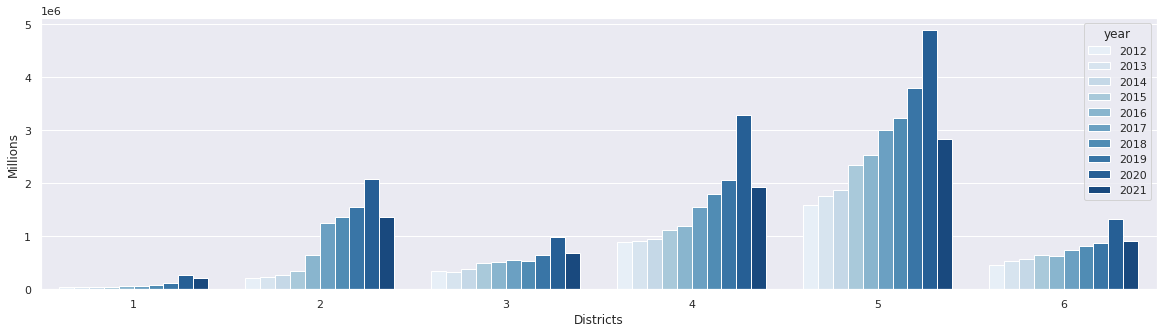

In [23]:

plt.figure(figsize=(20,5))

sns.set_theme(style="darkgrid")
x = sales_district_year['district']
y = sales_district_year['sale_dollars']
hue = sales_district_year.index
ax = sns.barplot(y=y, x=x, hue=hue, palette='Blues')

ax.set(xlabel='Districts', ylabel='Millions')

By plotting sales by ditrict over the years we can see that there is year over year sales growth.

[Text(0, 0.5, 'Millions'), Text(0.5, 0, 'Districts')]

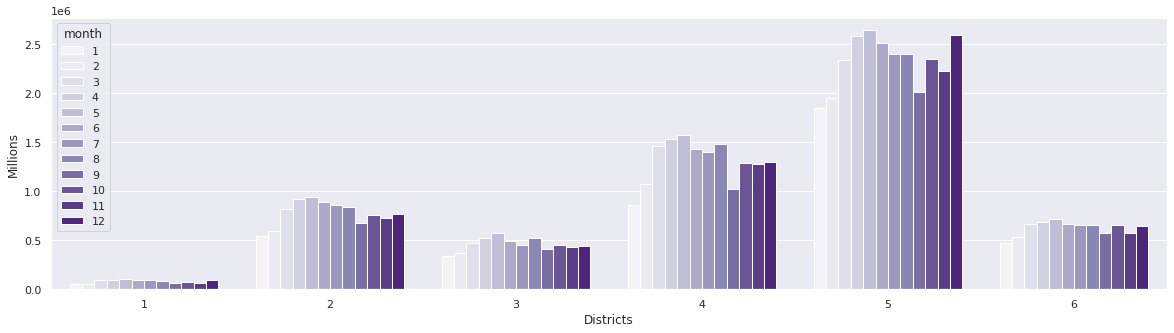

In [24]:
plt.figure(figsize=(20,5))

sns.set_theme(style="darkgrid")
x = sales_district_month['district']
y = sales_district_month['sale_dollars']
hue = sales_district_month.index
ax = sns.barplot(y=y, x=x, hue=hue, palette='Purples')

ax.set(xlabel='Districts', ylabel='Millions')

In [25]:
sales_district_year = new_df.groupby(['district','year'])['sale_dollars'].agg('sum')
sales_district_month = new_df.groupby(['district','month'])['sale_dollars'].agg('sum')
sales_district_week = new_df.groupby(['district','week'])['sale_dollars'].agg('sum')
#sales_district.sort_values(ascending=True).head()
sales_district_year = sales_district_year.reset_index(level='district')
sales_district_month = sales_district_month.reset_index(level='district')
sales_district_week = sales_district_week.reset_index(level='district')

##**Regression Models**
Let the best model win!

In [49]:
#establishing what my independent and dependent variable should be
df_reg.sort_index(ascending=True)

X = df_reg.drop(columns="sale_dollars")

y = df_reg['sale_dollars']
test_size = 0.2
date_col = df_reg.index

In [50]:
# using train_test_split making sure that my data is not shuffled since it is time series
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, shuffle= False)

Now that we have our data training data we can begin applying different models

In [28]:
!pip install joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [29]:
#!pip install sklearn.tree
from sklearn.preprocessing import StandardScaler
#X = StandardScaler().fit_transform(X)
# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

# Tree based models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# higher the alpha value, more restriction on the coefficients; low alpha > more generalization,
alpha = 0.01
max_iter = 10e5
max_depth = [2,3,4,5]
n_estimators = 100

# Construct some pipelines
#Linear Regression
pipe_lr = Pipeline([('scl', StandardScaler()),
			('clf', LinearRegression())])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
      ('clf', LinearRegression())])

#Ridge Regression
pipe_rr = Pipeline([('scl', StandardScaler()),
			('clf', Ridge(alpha=alpha))])

pipe_rr_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', Ridge(alpha=alpha))])

#Lasso Regressor
pipe_la = Pipeline([('scl', StandardScaler()),
			('clf', Lasso(alpha=alpha, max_iter=max_iter))])

pipe_la_pca = Pipeline([('scl', StandardScaler()),
			('clf', Lasso(alpha=alpha, max_iter=max_iter))])

#Linear Support Vector Regressor
pipe_svr = Pipeline([('scl', StandardScaler()),
			('clf', SVR(kernel = 'rbf'))])

pipe_svr_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', SVR(kernel = 'rbf'))])

#Decision Tree Regressor
pipe_dtr = Pipeline([('scl', StandardScaler()),
			('clf', DecisionTreeRegressor(max_depth=max_depth))])

#Random Forest Regression
pipe_rfr = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestRegressor()) ])

pipe_xgbr = Pipeline([('scl', StandardScaler()),
			('clf', XGBRegressor(verbosity=0))])


In [52]:
# Fitting the pipelines constructed in previous steps
pipe_lr.fit(X_train, y_train)
pipe_lr_pca.fit(X_train, y_train)
pipe_rr.fit(X_train, y_train)
pipe_rr_pca.fit(X_train, y_train)
pipe_la.fit(X_train, y_train)
pipe_la_pca.fit(X_train, y_train)
pipe_svr.fit(X_train, y_train)
pipe_svr_pca.fit(X_train, y_train)
#pipe_dtr.fit(X_train, y_train)
pipe_rfr.fit(X_train, y_train)
pipe_xgbr.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=0))],
         verbose=False)

In [53]:
# Scoring my models
LinearRegressionScore = pipe_lr.score(X_test,y_test)
LinearRegressionPCAScore = pipe_lr_pca.score(X_test,y_test)

RidgeRegressionScore = pipe_rr.score(X_test,y_test)
RidgeRegressionPCAScore = pipe_rr_pca.score(X_test,y_test)

LassoRegressorScore = pipe_la.score(X_test,y_test)
LassoRegressorPCAScore = pipe_la_pca.score(X_test,y_test)

SupportVectorRegressorScore = pipe_svr.score(X_test,y_test)
SupportVectorRegressorPCAScore = pipe_svr_pca.score(X_test,y_test)

#DecisionTreeRegressorScore = pipe_dtr.score(X_test,y_test)
RandomForestRegressionScore = pipe_rfr.score(X_test,y_test)
ExtremeGradientBoostingRegressorScore = pipe_xgbr.score(X_test,y_test)


print('The Linear Regression Models scored', LinearRegressionScore, LinearRegressionPCAScore)
print('The Ridge Regression Models scored', RidgeRegressionScore, RidgeRegressionPCAScore)
print('The Lasso Regression Models scored',LassoRegressorScore, LassoRegressorPCAScore)
print('The Support Vector Regressor Models scored', SupportVectorRegressorScore, SupportVectorRegressorPCAScore)
print('The Tree Models scored', RandomForestRegressionScore, ExtremeGradientBoostingRegressorScore)

The Linear Regression Models scored 0.9820930391818724 0.9594242266806594
The Ridge Regression Models scored 0.9782148079135968 0.9594238072423339
The Lasso Regression Models scored 0.9817914119017176 0.9817914119017176
The Support Vector Regressor Models scored -0.7046090792985134 -0.704167417909769
The Tree Models scored 0.9259968297604692 0.925002182746255


**After trying a variety of Regression Models it looks like the Linear and Lasso Regressions worke the best in terms of accuracy of prediction sales data.**

###**ARIMA Model**

In [30]:
# Creating a different df for my ARIMA model
df_arima = df_reg

df_arima

,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
date,,,,,,
2012-01-03,1646.48,2469.79,784,15105.42,403.23,106.65
2012-01-04,1371.22,2056.89,431,8984.70,251.53,66.50
2012-01-05,2153.53,3230.34,1042,18980.12,511.03,135.17
2012-01-09,1418.60,2128.05,722,12762.83,341.10,90.21
2012-01-10,858.38,1287.57,575,8932.77,239.97,63.50
...,...,...,...,...,...,...
2021-08-26,2981.93,4473.68,2610,54705.15,1108.06,291.65
2021-08-27,3520.43,5281.68,3595,66636.80,1369.90,360.48
2021-08-29,60.98,91.48,8,458.92,4.70,1.23


In [31]:
#Testing if my data is trend stationary using the Dicky Fuller Statistical Test
from statsmodels.tsa.stattools import adfuller
results = adfuller(df_arima['sale_dollars'])
print(results)

(-3.3700448698839094, 0.012023425081358513, 24, 2296, {'1%': -3.4332013179632686, '5%': -2.862799647940788, '10%': -2.5674405676968886}, 50239.29311319079)


Dicky Fuller Test tells us a few things
1. There is a high likelyhood that the data is stationary because the test statistic (0th value) of the tuple is negative
2. The p value (1st value) of the tuple is less than 0.05 meaning we can safely reject the null hypothesis, reject the notion that the data is not stationary
3. The critical values contained within the dictionary within the tuple further support that the data is stationary given that I am using a test statisti of 5%

In [32]:
# using train_test_split making sure that my data is not shuffled since it is time series
from sklearn.model_selection import train_test_split
X = df_arima.index
y= df_arima

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, shuffle= False)

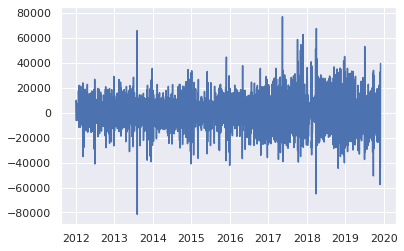

In [33]:
plt.plot(y_train.index,y_train['sale_dollars'].diff())
plt.show()

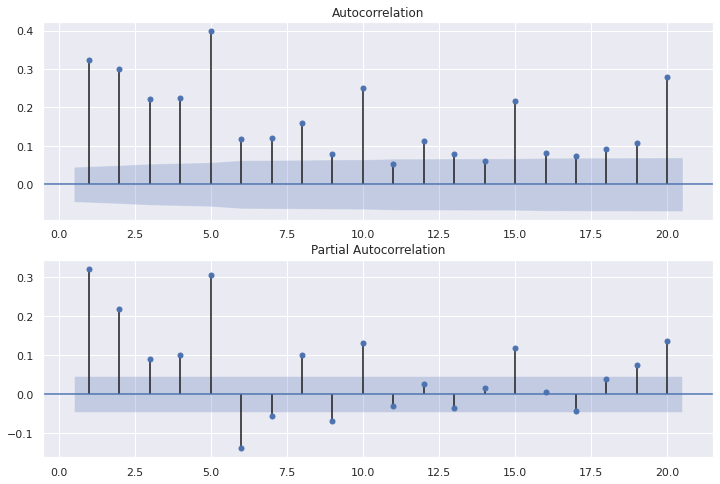

In [34]:
#determine the model order by plotting the acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df
plot_acf(y_train['sale_dollars'], lags=20, zero=False, ax=ax1)

# Plot the PACF of df
plot_pacf(y_train['sale_dollars'], lags=20, zero=False, ax=ax2)

plt.show()

In [35]:
# it is not clear what the order model should be so I will be using the aic and bic to determine this

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create empty list to store search results
order_aic_bic=[]

# Loop over p values
for p in range(10):
  # Loop over q values
    for q in range(10):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(y_train['sale_dollars'], order=(p,2,q))
        results = model.fit()

        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when 

In [36]:
#For order values that may cause errors
# Loop over p values from 0-2
#for p in range(3):
    # Loop over q values from 0-2
   # for q in range(3):
      
    #    try:
            # create and fit ARMA(p,q) model
     #       model = SARIMAX(y_train['sale_dollars'], order=(p,0,q))
      #      results = model.fit()
            
            # Print order and results
       #     print(p, q, results.aic, results.bic)
            
      #  except:
      #      print(p, q, None, None)     

In [37]:
#Make dataframe of model order
order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

#sort by aic
print(order_df.sort_values('aic').head())

#sort by bic
print(order_df.sort_values('bic').head())

#p = order_aic_bic['p'].min('aic')
#q = order_aic_bic['q'].min('aic')


    p  q           aic           bic
99  9  9  39849.830848  39954.807762
89  8  9  39855.310210  39954.762024
59  5  9  39871.499380  39954.375891
88  8  8  39877.443745  39971.370458
96  9  6  39883.334548  39971.736160
    p  q           aic           bic
59  5  9  39871.499380  39954.375891
89  8  9  39855.310210  39954.762024
99  9  9  39849.830848  39954.807762
88  8  8  39877.443745  39971.370458
96  9  6  39883.334548  39971.736160


In [38]:
# Based on the above results the best values for p & q that optimize prediction would be (9,2,9)
# But for explanability they are (4,2,8)
p = 4
q = 8
print('for our model the order value for p is :',p,'q is :',q)

for our model the order value for p is : 4 q is : 8


In [39]:
# Fit an ARMA model to the data
model = ARMA(y_train['sale_dollars'], order=(p,q), exog=y_train['volume_sold_liters'])
res = model.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta (and the constant) are:")
print(res.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:           sale_dollars   No. Observations:                 1856
Model:                     ARMA(4, 8)   Log Likelihood              -16123.914
Method:                       css-mle   S.D. of innovations           1432.998
Date:                Mon, 20 Sep 2021   AIC                          32277.829
Time:                        01:29:24   BIC                          32360.722
Sample:                             0   HQIC                         32308.381
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -510.9981   2965.194     -0.172      0.863   -6322.672    5300.676
volume_sold_liters    40.9867      0.122    337.021      0.000      40.748      41.225
ar.L1.sale_dollars  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [40]:

# Fit an SARIMA model to the data
model = SARIMAX(y_train['sale_dollars'], order=(p,2,q), trend = 'c')
                #,exog=y_train['volume_sold_liters'])
results = model.fit()

# Print out summary information on the fit
print(results.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta (and the constant) are:")
print(results.params)



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:           sale_dollars   No. Observations:                 1856
Model:               SARIMAX(4, 2, 8)   Log Likelihood              -19943.872
Date:                Mon, 20 Sep 2021   AIC                          39915.744
Time:                        01:29:45   BIC                          39993.095
Sample:                             0   HQIC                         39944.254
                               - 1856                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.7147      3.548      0.765      0.444      -4.239       9.669
ar.L1         -0.9982      0.022    -45.571      0.000      -1.041      -0.955
ar.L2         -0.9811      0.028    -35.553      0.0

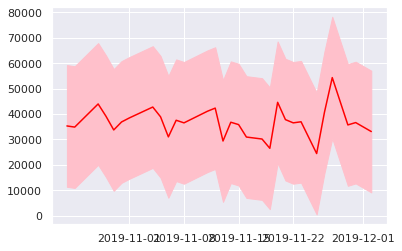

In [41]:
# make an insample prediction of last 30 days
forecast = results.get_prediction(start=-30)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
#print(confidence_intervals)
lower_limits = confidence_intervals.loc[:,'lower sale_dollars']
upper_limits = confidence_intervals.loc[:,'upper sale_dollars']

#plot values
plt.figure()
#plt.plot(y_train.index, y_train['sale_dollars'])
#plot prediction

plt.plot(mean_forecast.index,mean_forecast.values, color ='red',label='forecast')

#fill uncertainty area
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


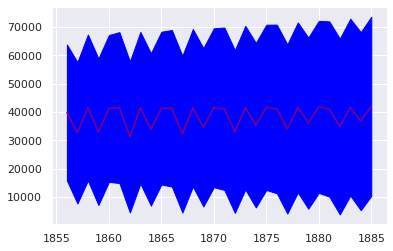

In [42]:
#Creating a 30 day forecast
forecast =results.get_forecast(steps=30)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower sale_dollars']
upper_limits = confidence_intervals.loc[:,'upper sale_dollars']

#plot prediction
plt.figure()
plt.plot(mean_forecast.index,mean_forecast.values, color ='purple',label='forecast')

#fill uncertainty area
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='blue')
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8290.857949599538


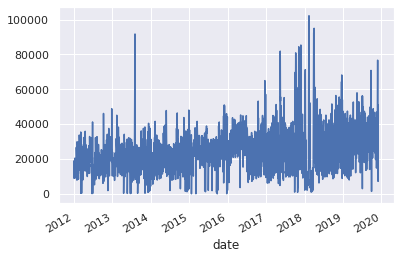

In [43]:
#verifying model performance
# Fit model
import numpy as np

model = SARIMAX(y_train['sale_dollars'], order=(p,2,q))
results = model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print(mae)

# Make plot of time series for comparison
y_train['sale_dollars'].plot()
plt.show()

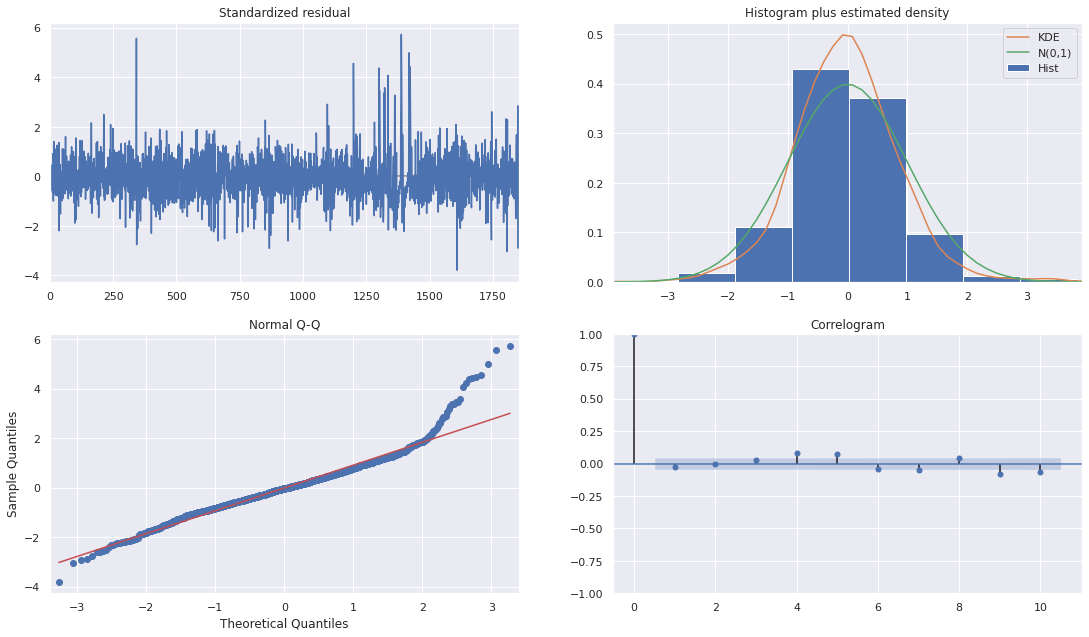

In [44]:
results.plot_diagnostics()

import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()


Seeing as though the model isn't quite where I would like it, I will try to account for the seasonality of the dataset

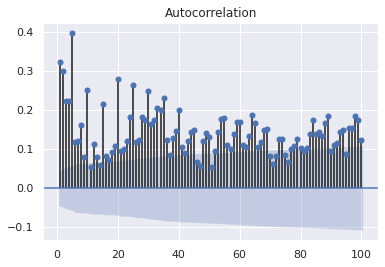

In [45]:
# Create figure and subplot
fig, ax1 = plt.subplots()

# Plot the ACF on ax1
plot_acf(y_train['sale_dollars'], lags=100, zero=False,  ax=ax1)

# Show figure
plt.show()

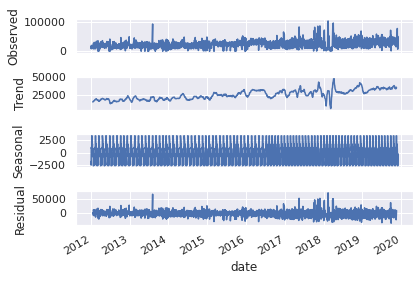

In [46]:
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(y_train['sale_dollars'], freq=20)

# Plot decomposition
decomp.plot()
plt.show()

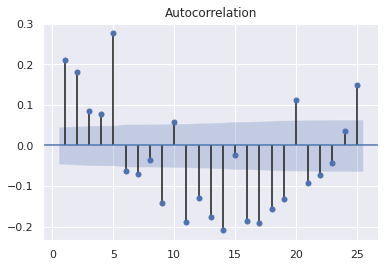

In [47]:
# Subtract the rolling mean
seasonal = y_train

seasonal = seasonal - seasonal.rolling(20).mean()

# Drop the NaN values
seasonal = seasonal.dropna()

# Create figure and subplots
fig, ax1 = plt.subplots()

# Plot the ACF
plot_acf(seasonal['sale_dollars'], lags=25, zero=False, ax=ax1)

# Show figure
plt.show()

Things to try 
- taking the log value of the time series data
- increasing the number of lags for p and q
- a different model
